## 1. Importing packages and data
<p><img src="https://assets.datacamp.com/production/project_458/img/candy.jpg" alt="Bowl of halloween candy"></p>
<p>Every year around Halloween it seems like everyone has candy on the brain! There's a great dataset from <a href="https://fivethirtyeight.com/">FiveThirtyEight</a> that includes all sorts of different information about different kinds of candy. For example, is a candy chocolaty? Does it have nougat? How does its cost compare to other candies? How many people prefer one candy over another?</p>
<p>We'll take a whirlwind tour of this dataset and wrap up by trying linear and logistic regression techniques out on it!</p>
<p>First things first, let's get our packages and data loaded up and inspect the data to see exactly what we're dealing with.</p>

In [193]:
# Load all the packages

library(dplyr)
library(tidyr)
library(ggplot2)
library(broom)
library(corrplot)
library(fivethirtyeight)
# Load the candy_rankings dataset from the fivethirtyeight package
data(candy_rankings)

# Take a glimpse() at the dataset

glimpse(candy_rankings)

Rows: 85
Columns: 13
$ competitorname   <chr> "100 Grand", "3 Musketeers", "One dime", "One quar...
$ chocolate        <lgl> TRUE, TRUE, FALSE, FALSE, FALSE, TRUE, TRUE, FALSE...
$ fruity           <lgl> FALSE, FALSE, FALSE, FALSE, TRUE, FALSE, FALSE, FA...
$ caramel          <lgl> TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, TRUE, FAL...
$ peanutyalmondy   <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, TRUE, TRUE, TRU...
$ nougat           <lgl> FALSE, TRUE, FALSE, FALSE, FALSE, FALSE, TRUE, FAL...
$ crispedricewafer <lgl> TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FA...
$ hard             <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F...
$ bar              <lgl> TRUE, TRUE, FALSE, FALSE, FALSE, TRUE, TRUE, FALSE...
$ pluribus         <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, T...
$ sugarpercent     <dbl> 0.732, 0.604, 0.011, 0.011, 0.906, 0.465, 0.604, 0...
$ pricepercent     <dbl> 0.860, 0.511, 0.116, 0.511, 0.511, 0.767, 0.767, 0...
$ winpercent       <dbl> 66.971

## 2. Explore the distributions of categorical variables
<p>Let's get started by looking at the distributions of each binary categorical variable. There are quite a few of them - we'll have to do some data wrangling to get them in shape for plotting. </p>
<p>We can get a sense of the proportion of <code>TRUE</code>s and <code>FALSE</code>s in each column by using the <code>gather()</code> function to get the dataset to look like this:</p>
<pre><code>  competitorname sugarpercent pricepercent winpercent feature   value
  &lt;chr&gt;                 &lt;dbl&gt;        &lt;dbl&gt;      &lt;dbl&gt; &lt;chr&gt;     &lt;lgl&gt;
1 100 Grand             0.732        0.860       67.0 chocolate TRUE 
2 3 Musketeers          0.604        0.511       67.6 chocolate TRUE 
3 One dime              0.011        0.116       32.3 chocolate FALSE
</code></pre>
<p>Then we can make a bar chart showing the number of <code>TRUE</code>s and <code>FALSE</code>s for each type of candy (<code>feature</code>).</p>
<p>Note: Development on <code>gather()</code> is complete, but it is still taught in several DataCamp courses. We will continue to use it here.</p>

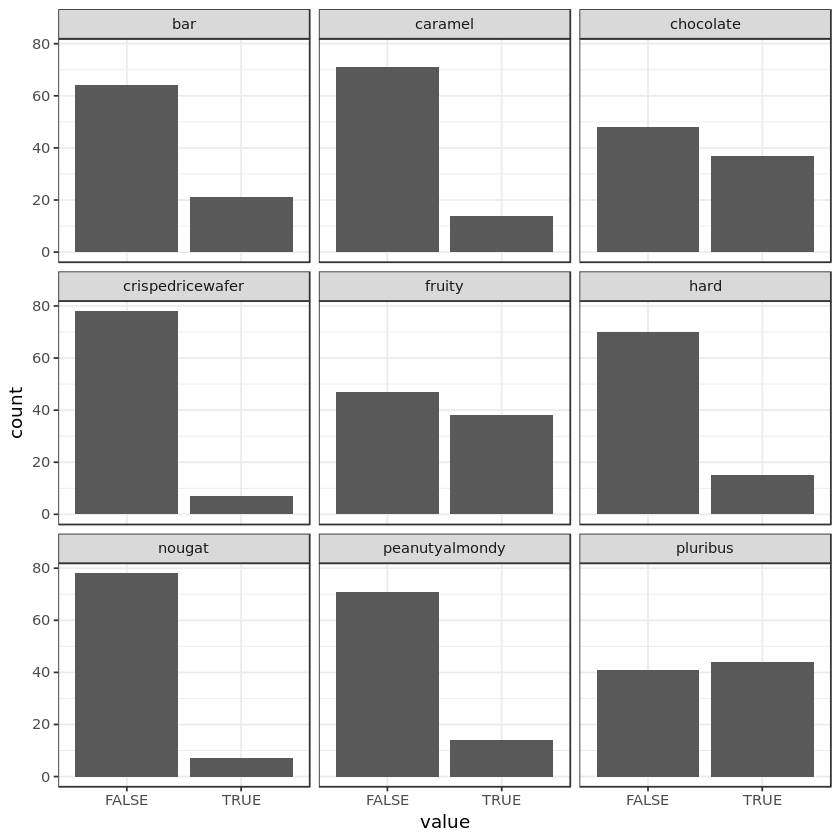

In [194]:
# Gather the categorical variables to make them easier to plot

#candy_rankings_long <- pivot_longer(candy_rankings, chocolate:pluribus, names_to = "feature", values_to = "value")
candy_rankings_long <- gather(candy_rankings, "feature", "value", chocolate:pluribus)

# Make a bar plot showing the distribution of each variable

ggplot(candy_rankings_long, aes(value)) +
geom_bar() +
facet_wrap(vars(feature)) +
theme_bw()

## 3. Taking a look at pricepercent
<p>Next, we'll look at the <code>pricepercent</code> variable. This variable records the percentile rank of the candy's price against all the other candies in the dataset. Let's see which is the most expensive and which is the least expensive by making a lollipop chart. One of the most interesting aspects of this chart is that a lot of the candies share the same ranking, so it looks like quite a few of them are the same price.</p>

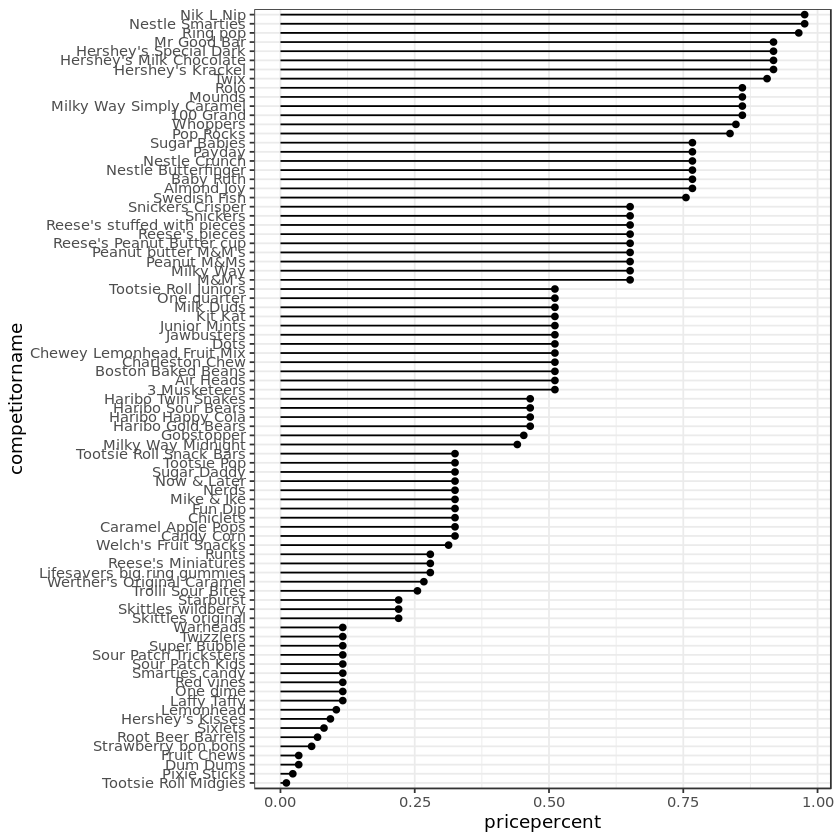

In [166]:
# Make a lollipop chart of pricepercent
ggplot(candy_rankings,  aes(reorder(competitorname, pricepercent), pricepercent)) +
geom_segment(aes(xend = reorder(competitorname, pricepercent), yend = 0)) +
geom_point() +
coord_flip() +
labs(
    x = "competitorname",
    y = "pricepercent"
    ) +
theme_bw()

## 4. Exploring winpercent (part i)
<p>Moving on, we'll take a look at another numerical variable in the dataset: <code>winpercent</code>. This variable is the percentage of people who prefer this candy over another randomly chosen candy from the dataset. </p>
<p>We'll start with a histogram! The distribution of rankings looks symmetrical and seems to center on about 45%! </p>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


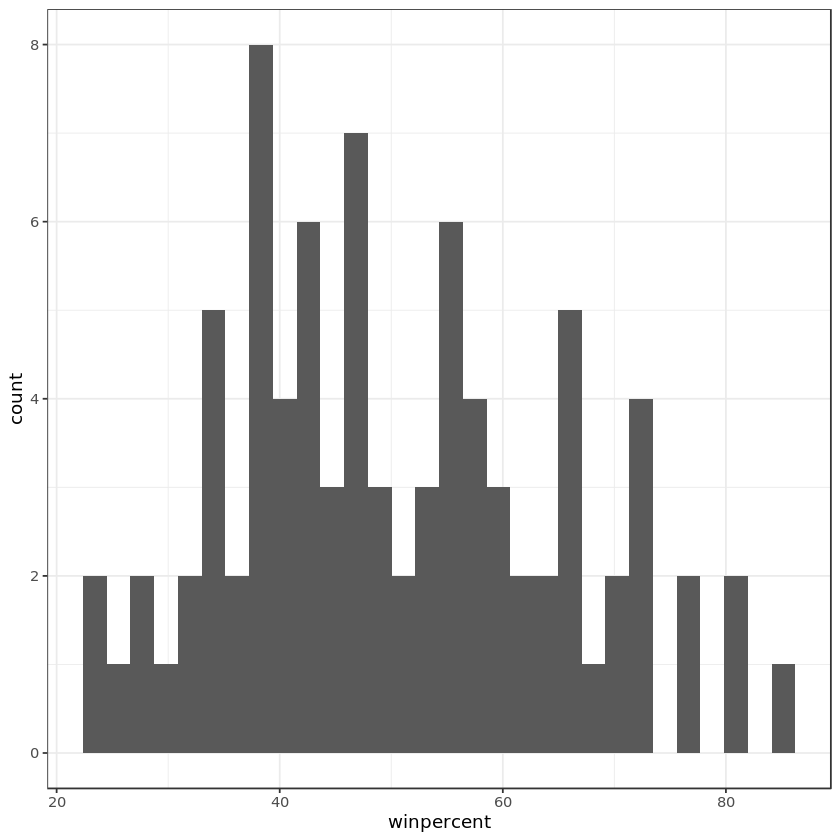

In [168]:
# Plot a histogram of winpercent

ggplot(candy_rankings, aes(winpercent)) +
geom_histogram() +
theme_bw()

## 5. Exploring winpercent (part ii)
<p>Now that we've looked at the histogram, let's make another lollipop chart to visualize the rankings. It looks like Reese's Peanut Butter Cups are the all time favorite out of this set of candies!</p>

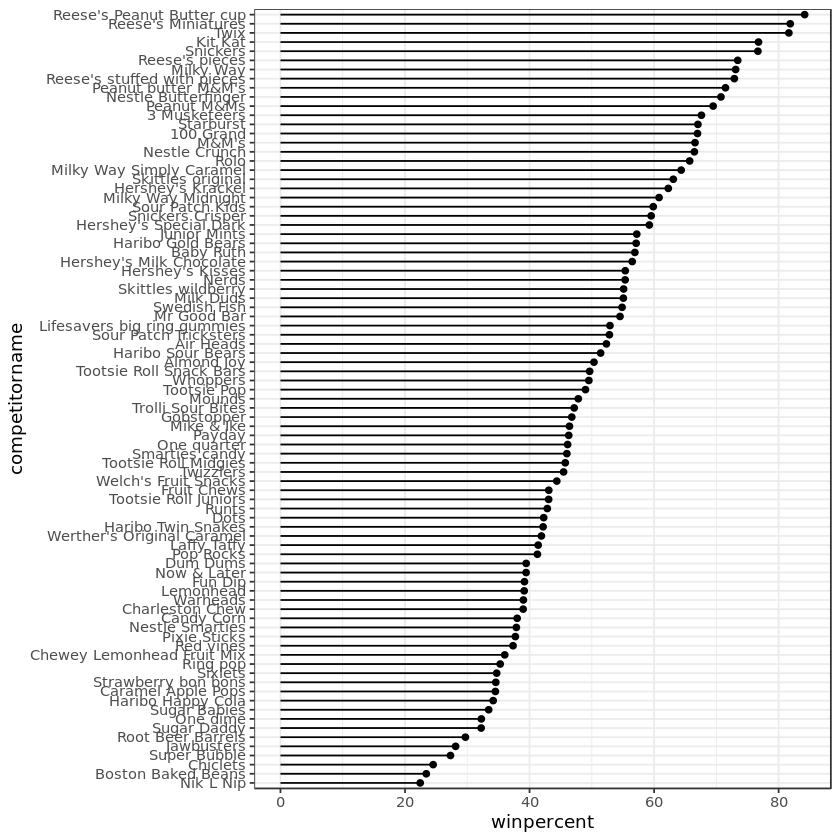

In [170]:
# Make a lollipop chart of winpercent


ggplot(candy_rankings,  aes(reorder(competitorname, winpercent), winpercent)) +
geom_segment(aes(xend = reorder(competitorname, winpercent), yend = 0)) +
geom_point() +
coord_flip() +
labs(
    x = "competitorname",
    y = "winpercent"
    ) +
theme_bw()

## 6. Exploring the correlation structure
<p>Now that we've explored the dataset one variable at a time, we'll see how the variables interact with one another. This is important as we get ready to model the data because it will give us some intuition about which variables might be useful as explanatory variables. </p>
<p>We'll use the <code>corrplot</code> package to plot a correlation matrix. Taking a look at this plot, it looks like chocolaty candies are almost never fruity. I can certainly see why that's the case! This also allows us to check for possible <a href="https://en.wikipedia.org/wiki/Multicollinearity">multicollinearity</a>, which can be a problem for regression modeling. It looks like we're good though!</p>

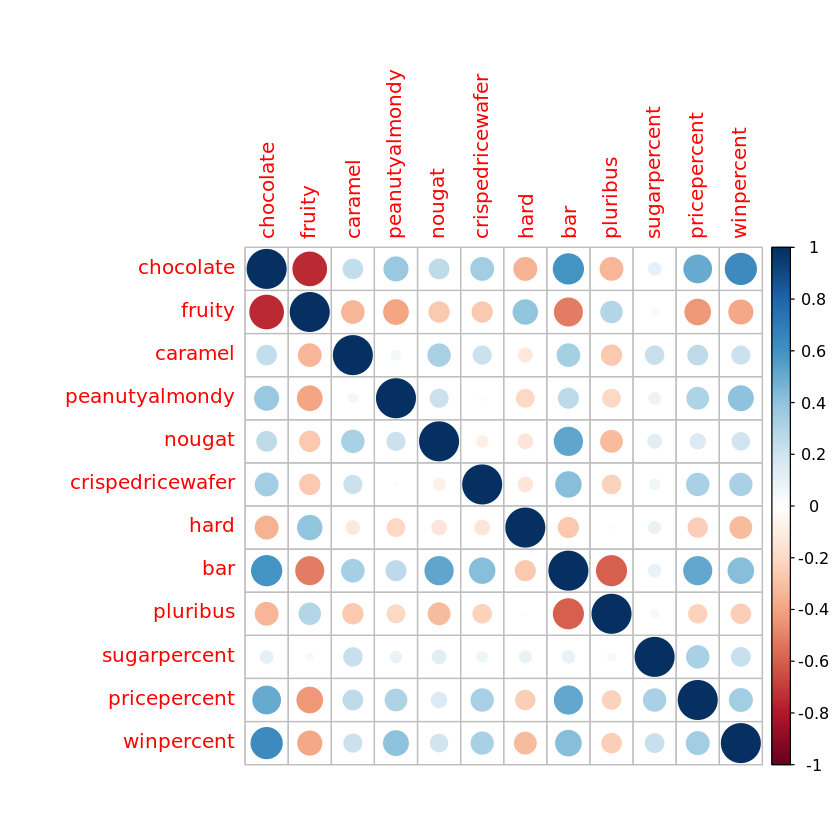

In [172]:
# Plot the correlation matrix
candy_rankings %>%
    select(-competitorname) %>%
    cor() %>%
    corrplot()


## 7. Fitting a linear model of winpercent
<p><img src="https://assets.datacamp.com/production/project_458/img/snickers.jpg" style="float: left;margin:5px 20px 5px 1px;max-width: 33%"></p>
<p>Let's dive into the deep end of modeling by creating a linear model of <code>winpercent</code> using all the other variables except <code>competitorname</code>. </p>
<p>Because <code>competitorname</code> is a categorical variable with a unique value in every row, it is mathematically impossible to fit a linear model if it is included. Moreover, this variable doesn't add any information that the model could use because the names do not relate to any of the candies' attributes.</p>
<p>Let's fit the model! Then we can dive into exploring it. Maybe this will give us an idea of why people tend to prefer one candy over another!</p>

In [174]:
# Fit a linear model of winpercent explained by all variables 
# except competitorname
win_mod <- lm(winpercent ~ . + 0 -competitorname, data = candy_rankings)

## 8. Evaluating the linear model
<p>Let's see how we did! We'll take a look at the results of our linear model and run some basic diagnostics to make sure the output is reliable.</p>
<p>Taking a look at the coefficients, we can make some conclusions about the factors that cause people to choose one candy over another. For example, it looks like people who took this survey really like peanut butter! There are a few other significant coefficients. Which ones are these?</p>


Call:
lm(formula = winpercent ~ . + 0 - competitorname, data = candy_rankings)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.2244  -6.6247   0.1986   6.8420  23.8680 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
chocolateFALSE        34.5340     4.3199   7.994 1.44e-11 ***
chocolateTRUE         54.2820     4.3113  12.591  < 2e-16 ***
fruityTRUE             9.4223     3.7630   2.504  0.01452 *  
caramelTRUE            2.2245     3.6574   0.608  0.54493    
peanutyalmondyTRUE    10.0707     3.6158   2.785  0.00681 ** 
nougatTRUE             0.8043     5.7164   0.141  0.88849    
crispedricewaferTRUE   8.9190     5.2679   1.693  0.09470 .  
hardTRUE              -6.1653     3.4551  -1.784  0.07852 .  
barTRUE                0.4415     5.0611   0.087  0.93072    
pluribusTRUE          -0.8545     3.0401  -0.281  0.77945    
sugarpercent           9.0868     4.6595   1.950  0.05500 .  
pricepercent          -5.9284     5.5132  -1.075  0.28578

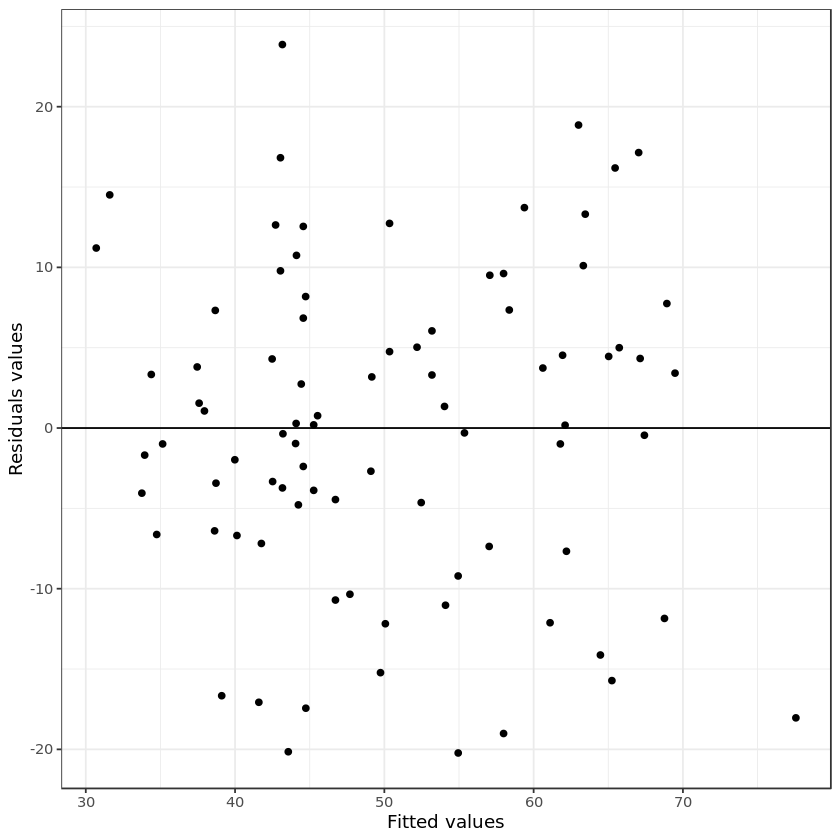

In [176]:
# Take a look at the summary

summary(win_mod)

# Plot the residuals vs the fitted values
augment(win_mod) %>%
    ggplot(aes(x = .fitted, y = .resid)) +
    geom_point() +
    geom_hline(yintercept = 0) +
    labs(
        x = "Fitted values",
        y = "Residuals values"
    ) +
    theme_bw()


## 9. Fit a logistic regression model of chocolate
<p><img src="https://assets.datacamp.com/production/project_458/img/chocolate.jpg" style="float: left;margin:5px 20px 5px 1px;max-width: 33%"></p>
<p>Now let's try out logistic regression! We'll be trying to predict if a candy is chocolaty or not based on all the other features in the dataset. </p>
<p>A logistic regression is a great choice for this particular modeling task because the variable we're trying to predict is either <code>TRUE</code> or <code>FALSE</code>. The logistic regression model will output a probability that we can use to make our decision. </p>
<p>This model outputs a warning because a few of the features (like <code>crispedricewafer</code>) are only ever true when a candy is chocolate. This means that we cannot draw conclusions from the coefficients, but we can still use the model to make predictions!</p>

In [178]:
# Fit a glm() of chocolate
choc_mod <- glm(chocolate ~ . + 0 -competitorname, data = candy_rankings, family = "binomial")

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

## 10. Evaluate the logistic regression model
<p>Let's take our logistic regression model out for a spin! We'll start by creating a data frame of predictions we can compare to the actual values. Then we'll evaluate the model by making a confusion matrix and calculating the accuracy.</p>
<p>Looking at the summary, it looks like most of the coefficients aren't statistically significant. In this case, that's okay because we're not trying to draw any conclusions about the relationships between the predictor variables and the response. We're only trying to make accurate predictions and, taking a look at our confusion matrix, it seems like we did a pretty good job!</p>

In [191]:
# Print the summary

summary(choc_mod)

# Make a data frame of predictions
preds <- augment(choc_mod, type.predict = "response") %>%
    mutate(
        prediction = ifelse(.fitted >= 0.5, TRUE, FALSE)
    )
# Create the confusion matrix
conf_mat <- table(preds$chocolate, preds$prediction)

conf_mat
# Calculate the accuracy
accuracy <- sum(diag(conf_mat))/sum(conf_mat) 

print(paste0("The accuracy of the model is ", scales::percent(accuracy, accuracy = 1.11)))


Call:
glm(formula = chocolate ~ . + 0 - competitorname, family = "binomial", 
    data = candy_rankings)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.72224  -0.17612  -0.02787   0.01954   2.57898  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)   
fruityFALSE           -10.29370    4.12040  -2.498  0.01248 * 
fruityTRUE            -17.04675    5.90620  -2.886  0.00390 **
caramelTRUE            -1.85093    1.66750  -1.110  0.26700   
peanutyalmondyTRUE     -4.11907    2.98175  -1.381  0.16715   
nougatTRUE            -16.74818 3520.13323  -0.005  0.99620   
crispedricewaferTRUE   14.98331 4725.35051   0.003  0.99747   
hardTRUE                1.83504    1.80742   1.015  0.30997   
barTRUE                19.06799 3520.13379   0.005  0.99568   
pluribusTRUE            0.22804    1.45457   0.157  0.87542   
sugarpercent            0.12168    2.07707   0.059  0.95329   
pricepercent            1.76626    2.24816   0.786  0.43208   

       
        FALSE TRUE
  FALSE    47    1
  TRUE      2   35

[1] "The accuracy of the model is 96.57%"
